<a href="https://colab.research.google.com/github/raemisch/Rosetta_tools_scripts/blob/master/CollagenDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.0 MB/s eta 0:00:00


In [10]:
#@title Imports / Definitions

import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource,  ColorBar
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.palettes import Viridis256
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqIO import parse


class InteractiveDataFrameTable:
    def __init__(self, df):
        self.df = df
        self.selected_indices = set()
        self.table_output = widgets.Output()

    def render_table(self):
        with self.table_output:
            self.table_output.clear_output()
            self.data_table = widgets.Output()

            with self.data_table:
                self.data_table.clear_output()
                display(self.df)

            display(self.data_table)

    def create_table(self):
        self.render_table()

        select_button = widgets.Button(description="Select Rows")
        select_button.on_click(self.on_select_button_click)

        display(widgets.VBox([self.table_output, select_button]))

    def on_select_button_click(self, _):
        selected_rows = []
        for index, row in self.df.iterrows():
            if index in self.selected_indices:
                selected_rows.append(row)

        if selected_rows:
            selected_df = pd.DataFrame(selected_rows)
            display(selected_df)


class InteractiveDataFrameSelector:
    def __init__(self, df):
        self.df = df
        self.checkboxes = []
        self.selected_df = None


    def create_selectable_table(self):
        rows = []
        # Create the header row
        column_headers = ['select'] + df_all.columns.to_list()
        header_row_widget = widgets.GridBox([widgets.HTML(f"<div style='width: auto; padding: 5px; background-color: #cccccc; text-align: center'>{header}</div>") for header in column_headers],
            layout=widgets.Layout(
                grid_template_columns="repeat(auto-fit, minmax(80px, 1fr))",
                grid_gap="5px"
        ))
        rows.append(header_row_widget)
        r = 0
        for index, row in self.df.iterrows():
            checkbox = widgets.Checkbox(value=False, description=str(index))
            #row_widget = widgets.HBox([checkbox] + [widgets.Label(str(row[col])) for col in self.df.columns])
            #row_widget = widgets.HBox([checkbox] + [widgets.HTML(f"<div style='width: 100%;'>{str(row[col])}</div>") for col in self.df.columns])

            row_widget = widgets.GridBox([checkbox] + [
                widgets.HTML(f"<div style='width: auto; background-color: {'#f2f2f2' if r % 2 == 0 else '#ffffff'}; text-align: center;text-overflow: ellipsis; overflow: hidden; margin:0; '>{str(row[col])}</div>")
                for i, col in enumerate(self.df.columns)
            ], layout=widgets.Layout(grid_template_columns="repeat(auto-fit, minmax(10px, 1fr)"), grid_gap="0px")


            rows.append(row_widget)
            self.checkboxes.append(checkbox)
            r += 1

        # Create a VBox widget to display the table

        table_widget = widgets.VBox(rows)
        table_widget.layout.width = '80%'  # Adjust the width as needed
        display(table_widget)

    def save_selected_rows(self):
        selected_indices = [index for index, checkbox in enumerate(self.checkboxes) if checkbox.value]
        self.selected_df = self.df.iloc[selected_indices]

    def display_selected_rows(self):
        if self.selected_df is not None:
            display(self.selected_df)

class TopMpnns():

    def __init__(self, basename):
        self.top_mpnns = {}
        self.basename = basename

    def add(self, num, df, idxs):
        for i in idxs:
            self.top_mpnns[f">{self.basename}_{num}_{i}"] = f"{df[df['name'] == f'{i}']['sequence'].values[0]}"

    def print_fasta(self):
        out = ""
        for n,s in self.top_mpnns.items():
            print(f"{n}\n{s}")
            out += f"{n}\n{s}\n"
        return out


class TopScores:
    def __init__(self, start):
        # Initialize an empty list to hold score-sequence pairs
        self.start = start
        self.scores = [{'score': -999999, 'seq': '', 'start': start}]
        self.top_n = 3

    def add_score(self, params):
        """
        Add a new score-sequence pair to the list if the score is among the top 20.
        """

        if score > self.scores[-1]['score']:
            # Append the new score-sequence pair
            self.scores.append({key: value for key,value in params.items()})
            # Sort the list of scores in descending order
            #self.scores.sort(reverse=True, key=lambda x: x[0])
            self.scores.sort(reverse=True, key=lambda x: x['score'])
            # Keep only the top_n scores
            if len(self.scores) > self.top_n:
                #print('old:', self.scores)
                deleted = self.scores.pop()
                #
                # print(f'new: {self.scores}')


    def __str__(self):
        """
        String representation of the top scores.
        """
        return '\n'.join([f'Score: {score}, Sequence: {seq}' for score, seq in self.scores])




def protParam(seq: str) -> dict:
    PA = ProteinAnalysis(seq)
    d = {}
    d = {"MW": "%.2f" % PA.molecular_weight()}
    d["PI"] = "%.2f" % PA.isoelectric_point()
    # d["ABS280 (red)"] = "%.2f" % PA.molar_extinction_coefficient()[0]
    # d["ABS280 (ox)"] = "%.2f" % PA.molar_extinction_coefficient()[1]
    d["Net Charge (pH7)"] = round(PA.charge_at_pH(7.0))
    gly_sites = findall(r"N[^P][ST]", seq)
    d["Glycosylation Sites"] = len(gly_sites)
    d["GRAVY"] = "%.2f" % PA.gravy()
    kex_sites = findall(r"[RKTP]R", seq)
    pepA_sites = findall(r"LLVY", seq)
    yapsin_1_sites = findall(r"SMIKR[NR]LQ[SGL]", seq)
    papA_sites = findall(r"EPAX[AHP]W", seq)
    prbA_sites = findall(r"[ALSK]FF[KALS]", seq)
    prbB_sites = findall(r"RF|WM|LY|FF", seq)
    d["KEX2 sites"] = len(kex_sites)
    d["PepA sites"] = len(pepA_sites)
    d["Yapsin_1 sites"] = len(yapsin_1_sites)
    d["Pap sites"] = len(papA_sites)
    d["PrbA sites"] = len(prbA_sites)
    d["PrbB sites"] = len(prbB_sites)
    return d




def quadratic_function(x, a, b, c):
    """Calculate the value of the quadratic function at x."""
    return a * x**2 + b * x + c

def calculate_score(x, target, a, b, c):
    """
    Calculate the score based on the difference between the target value
    and the value of the quadratic function at x.

    :param x: The input value for the quadratic function.
    :param target: The target value to compare against.
    :param a: The coefficient of x^2 in the quadratic function.
    :param b: The coefficient of x in the quadratic function.
    :param c: The constant term in the quadratic function.
    :return: The calculated score.
    """
    # Calculate the value of the quadratic function
    value = quadratic_function(x, a, b, c)

    # Calculate the difference between the value and the target
    difference = abs(target - value)

    # Score could be defined as the inverse of the difference
    # To prevent division by zero, ensure the difference is not zero
    if difference == 0:
        score = float('inf')  # Perfect score
    else:
        score = 1 / difference  # Higher scores for closer matches

    return score


# wm_score



def mw_score(x, target_x, a=-1):
    """
    Calculate the y value of a quadratic function for a given x, where y equals 0 at target_x.

    :param x: The x value at which to calculate the y value of the quadratic function.
    :param a: The coefficient that defines the width and direction of the parabola.
    :param target_x: The x-coordinate where the function equals zero (x-intercept).
    :return: The y value of the quadratic function.
    """

    try:
        x = float(x)/1000
    except:
        x = x

    #print('x', x)
    #print('target_value', target_x)
    return abs(a * (x - target_x)**2)*-1


def gravy_score(gravy):
    return float(gravy) * -1


def plot_dist(df, key='score', bins=100):

       # Setup for displaying Bokeh plot in the notebook
       output_notebook()

       # Create a histogram
       hist, edges = np.histogram(df[key], bins=bins)
       means = []

       # Get mean score for each bin
       indx = 0
       df = df.sort_values(by=key)
       for n in hist:
              start = indx
              end = start + n
              slice = df['score'][start:end]
              means.append(slice.mean())
              #print(means[-1])
              indx += n

       hist_df = pd.DataFrame({'score': hist, 'left': edges[:-1], 'right': edges[1:]})
       hist_df['avg_score'] = means

       # Create a ColumnDataSource
       source = ColumnDataSource(hist_df)

       # Create a figure
       p = figure(height=400, width=600, title="Score Distribution",
                     x_axis_label=key, y_axis_label='Count')

       # Map colors based on 'avg_score' values
       mapper = linear_cmap(field_name='avg_score', palette=Viridis256,
                            low=hist_df['avg_score'].min(), high=hist_df['avg_score'].max())

       # Add a quad glyph with color mapping
       p.quad(bottom=0, top='score', left='left', right='right', source=source,
              fill_color=mapper, line_color='white', alpha=0.5)

       # Add color bar
       color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
       p.add_layout(color_bar, 'right')

       # Show the plot
       show(p)


def plot_heatmap(df):

    # Setup for displaying Bokeh plot in the notebook
    output_notebook()


    # Create a ColumnDataSource
    source = ColumnDataSource(df)

    # Create a figure
    p = figure(width=600, height=400, title="Heat Map of MW vs GRAVY",
              x_axis_label='MW', y_axis_label='GRAVY', tools="hover", tooltips=[("Score", "@score")])

    # Map colors based on 'score' values
    mapper = linear_cmap(field_name='score', palette=Viridis256, low=min(df['score']), high=max(df['score']))

    # Add squares to create the heat map
    p.square(x='MW', y='GRAVY', source=source, size=10, color=mapper, line_color=None)

    # Add color bar
    color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
    p.add_layout(color_bar, 'right')

    # Show the plot
    show(p)


def score_aro(seq):
    s_W = seq.count('W')
    s_FY = (seq.count('Y') + seq.count('F')) / 3
    return s_W + s_FY


def get_score(seq, params):
    score = (p_PI * target_pi-abs(float(params['PI']))) + (p_mw * mw_score(params['MW'], target_mw, a=a)) + (p_charge * abs(int(params['Net Charge (pH7)']))) + (p_gravy * gravy_score(params['GRAVY'])) + (p_aro) * score_aro(seq)
    return score




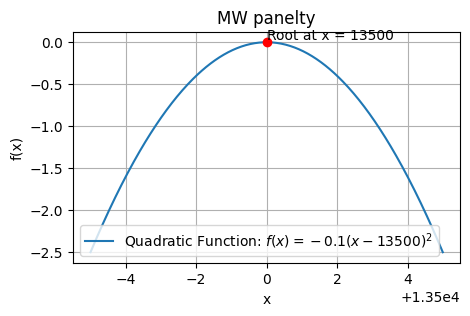

In [7]:
#@title Plot MW penalty function

# Generate a range of x values for plotting
x_values = np.linspace(target_mw - 5, target_mw + 5, 400)  # 400 points within a range around the target_x
y_values = mw_score(x_values, target_mw, a=a)

# Plot the function
plt.figure(figsize=(5, 3))
plt.plot(x_values, y_values, label=f'Quadratic Function: $f(x) = {a}(x - {target_mw})^2$')

# Mark the target_x where y equals 0
plt.plot(target_mw, 0, 'ro')  # 'ro' means red dot
plt.text(target_mw, 0, f'Root at x = {target_mw}', ha='left', va='bottom')

# Add title and labels
plt.title('MW panelty')
plt.xlabel('x')
plt.ylabel('f(x)')

# Add a grid
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [9]:
mw_score(18000, 13.5, a=a)

-2.025

In [6]:
# Human
hu_seq = "MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLRYHDRDVWKPEPCRICVCDNGKVLCDDVICDETKNCPGAEVPEGECCPVCPDGSESPTDQETTGVEGPKGDTGPRGPRGPAGPPGRDGIPGQPGLPGPPGPPGPPGPPGLGGNFAPQLSYGYDEKSTGGISVPGPMGPSGPRGLPGPPGAPGPQGFQGPPGEPGEPGASGPMGPRGPPGPPGKNGDDGEAGKPGRPGERGPPGPQGARGLPGTAGLPGMKGHRGFSGLDGAKGDAGPAGPKGEPGSPGENGAPGQMGPRGLPGERGRPGAPGPAGARGNDGATGAAGPPGPTGPAGPPGFPGAVGAKGEAGPQGPRGSEGPQGVRGEPGPPGPAGAAGPAGNPGADGQPGAKGANGAPGIAGAPGFPGARGPSGPQGPGGPPGPKGNSGEPGAPGSKGDTGAKGEPGPVGVQGPPGPAGEEGKRGARGEPGPTGLPGPPGERGGPGSRGFPGADGVAGPKGPAGERGSPGPAGPKGSPGEAGRPGEAGLPGAKGLTGSPGSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAAGEPGKAGERGVPGPPGAVGPAGKDGEAGAQGPPGPAGPAGERGEQGPAGSPGFQGLPGPAGPPGEAGKPGEQGVPGDLGAPGPSGARGERGFPGERGVQGPPGPAGPRGANGAPGNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDRGDAGPKGADGSPGKDGVRGLTGPIGPPGPAGAPGDKGESGPSGPAGPTGARGAPGDRGEPGPPGPAGFAGPPGADGQPGAKGEPGDAGAKGDAGPPGPAGPAGPPGPIGNVGAPGAKGARGSAGPPGATGFPGAAGRVGPPGPSGNAGPPGPPGPAGKEGGKGPRGETGPAGRPGEVGPPGPPGPAGEKGSPGADGPAGAPGTPGPQGIAGQRGVVGLPGQRGERGFPGLPGPSGEPGKQGPSGASGERGPPGPMGPPGLAGPPGESGREGAPGAEGSPGRDGSPGAKGDRGETGPAGPPGAPGAPGAPGPVGPAGKSGDRGETGPAGPAGPVGPVGARGPAGPQGPRGDKGETGEQGDRGIKGHRGFSGLQGPPGPPGSPGEQGPSGASGPAGPRGPPGSAGAPGKDGLNGLPGPIGPPGPRGRTGDAGPVGPPGPPGPPGPPGPPS"

# Chicken
ch_seq = "MFSFVDSRLLLLIAATVLLTRGEGEEDIQTGSCVQDGLTYNDKDVWKPEPCQICVCDSGNILCDEVICEDTSDCPNAEIPFGECCPICPDVDASPVYPESAGVEGPKGDTGPRGDRGLPGPPGRDGIPGQPGLPGPPGPPGPPGLGGNFAPQMSYGYDEKSAGVAVPGPMGPAGPRGLPGPPGAPGPQGFQGPPGEPGEPGASGPMGPRGPAGPPGKNGDDGEAGKPGRPGQRGPPGPQGARGLPGTAGLPGMKGHRGFSGLDGAKGQPGPAGPKGEPGSPGENGAPGQMGPRGLPGERGRPGPSGPAGARGNDGAPGAAGPPGPTGPAGPPGFPGAAGAKGETGPQGARGSEGPQGSRGEPGPPGPAGAAGPAGNPGADGQPGAKGATGAPGIAGAPGFPGARGPSGPQGPSGAPGPKGNSGEPGAPGNKGDTGAKGEPGPAGVQGPPGPAGEEGKRGARGEPGPAGLPGPAGERGAPGSRGFPGADGIAGPKGPPGERGSPGAVGPKGSPGEAGRPGEAGLPGAKGLTGSPGSPGPDGKTGPPGPAGQDGRPGPAGPPGARGQAGVMGFPGPKGAAGEPGKPGERGAPGPPGAVGAAGKDGEAGAQGPPGPTGPAGERGEQGPAGAPGFQGLPGPAGPPGEAGKPGEQGVPGNAGAPGPAGARGERGFPGERGVQGPPGPQGPRGANGAPGNDGAKGDAGAPGAPGNEGPPGLEGMPGERGAAGLPGAKGDRGDPGPKGADGAPGKDGLRGLTGPIGPPGPAGAPGDKGEAGPPGPAGPTGARGAPGDRGEPGPPGPAGFAGPPGADGQPGAKGETGDAGAKGDAGPPGPAGPTGAPGPAGZVGAPGPKGARGSAGPPGATGFPGAAGRVGPPGPSGNIGLPGPPGPAGKZGSKGPRGETGPAGRPGEPGPAGPPGPPGEKGSPGADGPIGAPGTPGPQGIAGQRGVVGLPGQRGERGFPGLPGPSGEPGKQGPSGASGERGPPGPMGPPGLAGPPGEAGREGAPGAEGAPGRDGAAGPKGDRGETGPAGPPGAPGAPGAPGPVGPAGKNGDRGETGPAGPAGPPGPAGARGPAGPQGPRGDKGETGEQGDRGMKGHRGFSGLQGPPGPPGAPGEQGPSGASGPAGPRGPPGSAGAAGKDGLNGLPGPIGPPGPRGRTGEVGPVGPPGPPGPPGPPGPPS"
ch_seq = ch_seq.replace('Z','E')

# Collagen @UniRef
fasta_file = '/Users/raemisch/Downloads/uniref_collagen_AND_taxonomy_id_7711_2023_10_17.fasta'

# seqs = {}
# with open(fasta_file, "r") as handle:
#     for record in SeqIO.parse(handle, "fasta"):
#         # Access the sequence ID and sequence data
#         sequence_id = record.id
#         sequence = str(record.seq)
#         seqs[sequence_id] = sequence

seqs = {'COL1A1_HUMAN': hu_seq}

In [7]:
#@title Parameters

#@markdown weights
p_mw = 1.0 #@param
p_gravy = 5 #@param
p_charge = 0.1 #@param
#p_kex = 1.5
p_PI = 1.5 #@param
p_aro = 1.0 #@param

#@markdown

#@markdown target values
target_pi = 6.5 #@param
target_mw = 13.500 #@param
#@markdown

#@markdown steepness of quadratic penalty

a = -0.1 #@param

In [11]:
#@title Run Design
import random
from Bio import SeqIO
from re import findall

score_objects = []
failed = []

# loop through sequences
for name,seq in seqs.items():
    if len(seq) < 300:
        continue
    seq = seq.replace('X','E')

    for idx in range(len(seq)-100):
        start = idx + 1
        score_obj = TopScores(start)
        current_threshold = score_obj.scores[-1]['score']

        for length in range(70,200):
            peptide = seq[start:start+length]
            if 'C' in peptide:
                continue
            params = protParam(peptide)
            if params['KEX2 sites'] == 0:
                score = get_score(peptide, params)
                 #+ (p_kex * -params['KEX2 sites'])
                if score > current_threshold:
                    params['score'] = score
                    params['start'] = start
                    params['end'] = start+length
                    params['seq'] = peptide
                    params['orig'] = name
                    params['aro_score'] = score_aro(peptide)
                    score_obj.add_score(params)
                    current_threshold = score_obj.scores[-1]['score']

        if score_obj.scores[0]['score'] > 0:
            #print('start', start)
            #print('Appending top scores. Best:', score_obj.scores[0]['score'])
            score_objects.append(score_obj)
        else:
            #print('failed at', start)
            failed.append(score_obj)

L = []
for obj in score_objects:
    #L.append({'start': obj.start, 'score': obj.scores[0][0], 'sequence': obj.scores[0][1]})
    L.append(obj.scores[0])

df_all = pd.DataFrame(L)
df_all = df_all[df_all['score'] > 0]
df_all['MW'] = df_all['MW'].astype('float')
df_all['GRAVY'] = df_all['GRAVY'].astype('float')


print(f"{len(df_all)} peptides found")
print(f'Best GRAVY', df_all['GRAVY'].min())
print(f"Max Net Charge", df_all['Net Charge (pH7)'].max())
print(f"Min Net Charge", df_all['Net Charge (pH7)'].min())

plot_dist(df_all, key='score')
plot_dist(df_all, key='start', bins=int(len(seq)/100))
plot_heatmap(df_all)

452 peptides found
Best GRAVY -1.16
Max Net Charge 3
Min Net Charge -4


In [43]:
df_all.sort_values(by='score', ascending=False).head(20)

,MW,PI,Net Charge (pH7),Glycosylation Sites,GRAVY,KEX2 sites,PepA sites,Yapsin_1 sites,Pap sites,PrbA sites,PrbB sites,score,start,end,seq,orig,aro_score
128,12726.65,5.17,-3,0,-0.87,0,0,0,0,0,0,10.170193,542,684,SPGSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGA...,COL1A1_HUMAN,1.000000
126,12884.80,5.16,-3,0,-0.86,0,0,0,0,0,0,10.152153,540,684,TGSPGSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPK...,COL1A1_HUMAN,1.000000
131,12485.40,5.17,-3,0,-0.87,0,0,0,0,0,0,10.127059,545,684,SPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAAGE...,COL1A1_HUMAN,1.000000
129,12639.57,5.17,-2,0,-0.87,0,0,0,0,0,0,10.055966,543,684,PGSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAA...,COL1A1_HUMAN,1.000000
127,12783.70,5.17,-2,0,-0.86,0,0,0,0,0,0,10.028691,541,684,GSPGSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKG...,COL1A1_HUMAN,1.000000
132,12398.33,5.17,-2,0,-0.87,0,0,0,0,0,0,10.008632,546,684,PGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAAGEP...,COL1A1_HUMAN,1.000000
130,12542.46,5.17,-2,0,-0.86,0,0,0,0,0,0,9.988312,544,684,GSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAAG...,COL1A1_HUMAN,1.000000
133,12301.21,5.17,-2,0,-0.86,0,0,0,0,0,0,9.936290,547,684,GPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAAGEPG...,COL1A1_HUMAN,1.000000
134,12244.16,5.17,-2,0,-0.86,0,0,0,0,0,0,9.922287,548,684,PDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAAGEPGK...,COL1A1_HUMAN,1.000000
124,13055.01,5.17,-2,0,-0.83,0,0,0,0,0,0,9.910198,538,684,GLTGSPGSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPG...,COL1A1_HUMAN,1.000000


In [9]:
df_all['start'].min()

219

In [10]:

max_GRAVY = -0.8
max_ERKD = 0.3
min_ERKD = 0.15

df = pd.DataFrame(L)
#df = df[df['score'] > 33.7]
#df = df[df['KEX2 sites'] == 0]
#df = df[df['MW'].str.startswith('2')]
df = df[df['Net Charge (pH7)'] > -20]
df = df[df['Net Charge (pH7)'] < 20]

df['GRAVY'] = pd.to_numeric(df['GRAVY'], errors='coerce')
df = df[df['GRAVY'] < max_GRAVY]

# Solubility
df['ERKD'] = df['seq'].apply(lambda x:(x.count('E')+x.count('K')+x.count('R')+x.count('D'))/len(x))
df = df[df['ERKD'] > min_ERKD]
df = df[df['ERKD'] < max_ERKD]

# Avoid some weird regions from animal collagens
#df['G'] = df['seq'].apply(lambda x:(x[0:6].count('G')))
#df = df[df['G'] > 1]

df = df[df['seq'].str.count('GPP') > 3]
df = df[['MW','Net Charge (pH7)','GRAVY','score', 'start','orig','seq']]

df = df.sort_values(by='score', ascending=False)
df.head(30)

,MW,Net Charge (pH7),GRAVY,score,start,orig,seq
205,13292.10,-3,-0.85,8.753517,699,COL1A1_HUMAN,NGAPGNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDR...
208,13049.86,-3,-0.85,8.729606,702,COL1A1_HUMAN,PGNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDRGDA...
210,12895.70,-3,-0.85,8.705223,704,COL1A1_HUMAN,NDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDRGDAGP...
203,12718.45,-3,-0.85,8.668377,697,COL1A1_HUMAN,GANGAPGNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKG...
209,12952.75,-3,-0.84,8.665078,703,COL1A1_HUMAN,GNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDRGDAG...
204,13363.17,-3,-0.83,8.657192,698,COL1A1_HUMAN,ANGAPGNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGD...
206,13177.99,-3,-0.83,8.644446,700,COL1A1_HUMAN,GAPGNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDRG...
207,13120.94,-3,-0.83,8.638447,701,COL1A1_HUMAN,APGNDGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDRGD...
211,12781.59,-3,-0.83,8.582583,705,COL1A1_HUMAN,DGAKGDAGAPGAPGSQGAPGLQGMPGERGAAGLPGPKGDRGDAGPK...
311,12173.00,-2,-0.95,8.565861,910,COL1A1_HUMAN,GETGPAGRPGEVGPPGPPGPAGEKGSPGADGPAGAPGTPGPQGIAG...


In [ ]:
# Create an instance of the InteractiveDataFrameSelector class
selector = InteractiveDataFrameSelector(df)

# Create the selectable table
selector.create_selectable_table()

# Create a button to save selected rows
save_button = widgets.Button(description="Save Selected Rows")
save_button.on_click(lambda b: selector.save_selected_rows())

# Create a button to display selected rows
display_button = widgets.Button(description="Display Selected Rows")
display_button.on_click(lambda b: selector.display_selected_rows())

# Display the buttons
display(widgets.HBox([save_button, display_button]))

NameError: name 'df_all' is not defined

In [ ]:
top_mpnns = TopMpnns('col1a1')
for i,row in selector.selected_df.iterrows():
    print(f">coll_{i}\n{row['seq']}")


>coll_9701
GQQGDAGPVGEMGFEGPPGPEGEPGLPGEPGEKGDIGPAGKAGEPGEQGLRGGPGPPGEDGTQGIDGSKGDSGDQGQAGEDGEKGETGIPGITGSPGEPGIMGTPGPEGTPGNPGQRGRPGKKGEKGQLGPPGETGPPGDPGHPGEIGPKGARGTRGPLGHLGEMGPEGEPGIPGYEGHKGLPGPPGPPGPKGEKGYPGEDNTVLGLPGPIGEPGPSGERGDRGEPGDEGYKGHVGLPGLRGAIGQQGPPGEPGELGEQGPKGERGSEGPTGKKGMSGQAG
>coll_9680
PGTQGIKGERGDAGKKGIHGLIGKAGNPGEQGDQGVPGLPGPPGSLGDRGPVGEPGSRGQQGDAGPVGEMGFEGPPGPEGEPGLPGEPGEKGDIGPAGKAGEPGEQGLRGGPGPPGEDGTQGIDGSKGDSGDQGQAGEDGEKGETGIPGITGSPGEPGIMGTPGPEGTPGNPGQRGRPGKKGEKGQLGPPGETGPPGDPGHPGEIGPKGARGTRGPLGHLGEMGPEGEPGIPGYEGHKGLPGPPGPPGPKGEKGYPGEDNTVLGLPGPIGEPGPSGERGDRGEPGDE
